# Training Notebook (XRay Classification)

This notebook trains a baseline CNN on XRay images using the labels you created in `inspect_dataset.ipynb`.

Requirements: `tensorflow`, `pandas`, `numpy`.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# Hyperparameters (centralized)
THRESHOLD = 0.036
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 5

# MobileNet settings
TRAIN_BACKBONE = False
DROPOUT = 0.2
LEARNING_RATE = 1e-3


In [3]:
# Load labeled data (rebuild mapping here so notebook is standalone)
import re
from pathlib import Path
import pandas as pd

csv_path = Path("CrackVoid Ratios") / "Xray Void Ratio.csv"
df = pd.read_csv(csv_path, sep=";")
df["Void rate"] = pd.to_numeric(df["Void rate"], errors="coerce")

df["label"] = (df["Void rate"] >= THRESHOLD).astype(int)

def key_from_row(r):
    return (r["Led Type"], int(r["Panel"]), int(r["LED Number"]))

lookup = {key_from_row(r): r for _, r in df.iterrows()}

xray_root = Path("XRay") / "XRay"
rows = []

for img_path in xray_root.rglob("*.jpg"):
    name = img_path.name
    parts = name.split("_")
    if len(parts) < 5:
        continue
    led_type = parts[1]
    panel = None
    led_num = None
    for part in parts:
        if part.startswith("Panel"):
            panel = int(re.sub(r"[^\d]", "", part))
        if part.startswith("LED"):
            led_num = int(re.sub(r"[^\d]", "", part))
    if panel is None or led_num is None:
        continue
    key = (led_type, panel, led_num)
    if key in lookup:
        r = lookup[key]
        rows.append({
            "path": str(img_path),
            "label": int(r["label"]),
            "void_rate": float(r["Void rate"]),
            "panel": panel,
        })

labeled = pd.DataFrame(rows)
labeled.head()


,path,label,void_rate,panel
0,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0,0.031611,1
1,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0,0.018718,1
2,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0,0.005978,1
3,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0,0.015036,1
4,XRay\XRay\FC-GB1\XRay_FC-GB1_SAC105_Panel1_LED...,0,0.023375,1


In [4]:
labeled["label"].value_counts()
labeled["void_rate"].describe()


count    1800.000000
mean        0.028636
std         0.023569
min         0.000000
25%         0.010268
50%         0.023420
75%         0.039848
max         0.107209
Name: void_rate, dtype: float64

In [5]:
# Train/val/test split with panel-level split to reduce leakage
from sklearn.model_selection import train_test_split

panels = labeled["panel"].unique()
train_panels, temp_panels = train_test_split(panels, test_size=0.3, random_state=42)
val_panels, test_panels = train_test_split(temp_panels, test_size=0.5, random_state=42)

train_df = labeled[labeled["panel"].isin(train_panels)].reset_index(drop=True)
val_df = labeled[labeled["panel"].isin(val_panels)].reset_index(drop=True)
test_df = labeled[labeled["panel"].isin(test_panels)].reset_index(drop=True)

train_df["label"].value_counts(), val_df["label"].value_counts(), test_df["label"].value_counts()

(label
 0    645
 1    255
 Name: count, dtype: int64,
 label
 0    375
 1     75
 Name: count, dtype: int64,
 label
 0    255
 1    195
 Name: count, dtype: int64)

In [6]:
# Create tf.data pipelines
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, label

def make_ds(df, shuffle=True):
    paths = df["path"].values
    labels = df["label"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42)
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_df, shuffle=True)
val_ds = make_ds(val_df, shuffle=False)
test_ds = make_ds(test_df, shuffle=False)

In [7]:
# MobileNetV2 (transfer learning)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = TRAIN_BACKBONE

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(DROPOUT)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

model.evaluate(test_ds)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 720ms/step - accuracy: 0.7267 - loss: 0.5230 - val_accuracy: 0.8889 - val_loss: 0.3991
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 672ms/step - accuracy: 0.8167 - loss: 0.3834 - val_accuracy: 0.8178 - val_loss: 0.3962
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 672ms/step - accuracy: 0.8389 - loss: 0.3501 - val_accuracy: 0.7822 - val_loss: 0.4146
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 662ms/step - accuracy: 0.8378 - loss: 0.3456 - val_accuracy: 0.7667 - val_loss: 0.4314
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 655ms/step - accuracy: 0.8589 - loss: 0.3185 - val_accuracy: 0.7933 - val_loss: 0.3965
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 444ms/step - accuracy: 0.7556 - loss: 0.5619


[0.5619468092918396, 0.7555555701255798]

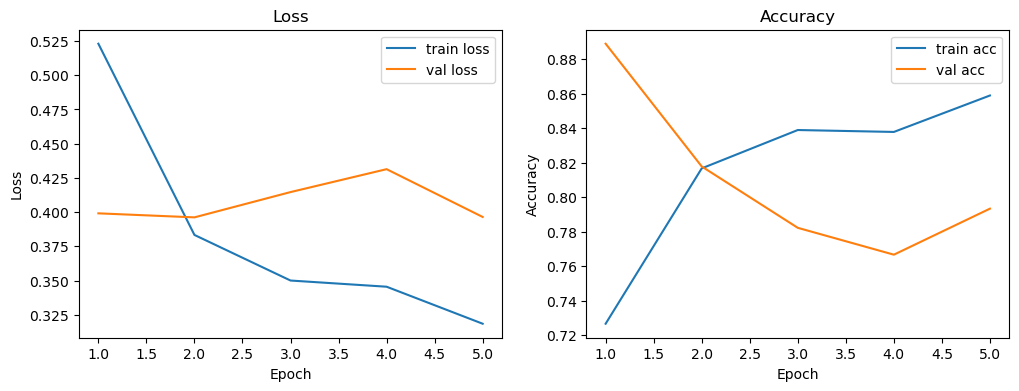

In [10]:
import matplotlib.pyplot as plt

def plot_history(hist):
    h = hist.history
    epochs = range(1, len(h["loss"]) + 1)

    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, h["loss"], label="train loss")
    plt.plot(epochs, h["val_loss"], label="val loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, h["accuracy"], label="train acc")
    plt.plot(epochs, h["val_accuracy"], label="val acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

plot_history(history)
